In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

from graphviz import Digraph

import datetime

from sklearn.preprocessing import StandardScaler
from src.data_collection.multimodal_data import *

# Deep Lyrics Generator - ULMFiT

## Set up instructions

### Create VM Instance

- Go to cloud.google.com, and create a new VM instance
- Disk size: 100GB or more
- CPUs + Memory: 2vCPUs, 7.5 GB Memory
- GPU: K80 (cheaper, less power) or P100 (2.5x more expensive, more power)
- Enable http, https traffic
- Boot: Deep learning pytorch instance

### Network configuration

In Google cloud platform:

- Go to Networking -> VPC Network, External IP addresses
- Select your VM instance and change the external address type from Ephemeral to Static
- Go to Networking -> VPC Network, Firewall Rules
- Add a new Rule, called Jupyter, ip ranges 0.0.0.0/0, protocols and ports tcp:8888, apply to all targets

### VM + Jupyter Setup

- SSH to VM
- Enlist into Github repo
- Run src/setup.sh
- Run jupyter notebook
- Open a google cloud shell
- Run gcloud init and answer the questions
- To set up a tunnel and run jupyter locally, run ```gcloud compute --project "<your project>" ssh --zone "<your zone>" "<your instance name>" -- -L 8888:localhost:8888```
- Open jupyter notebook in your local computer and have fun

### Notebook first run
Here are some steps to run the first time you use the notebook.

#### Tokens
To create the model's tokens with the correct train-test split, run ```src/data_collection/lm_data_lyrics.py -o path/to/save```. 
We recommend saving in data/models/{MODEL_NAME}. Alternatively, run the magic command below and replace the model name.

In [4]:
%run ../src/data_collection/lm_data_lyrics.py -o ../data/models/3.4-ULMFiT-MM-108k

Numericalizing train.
Numericalizing valid.


#### Aggregate Audio Features

To create the model's audio features with the same train-test split as the language models, run `src/data/lm_data_audio.py -o path/to/save`

In [6]:
%run ../src/data_collection/lm_data_audio.py -o ../data/interim/msd-aggregate

## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [26]:
init_model_name = '3.3-ULMFiT-108k'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')


model_name = '3.4-ULMFiT-MM-108k'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

In [5]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

print(data_lm.train_ds.vocab_size)

10002


In [6]:
train_text = copy(data_lm.train_ds)
valid_text = copy(data_lm.valid_ds)

#### Audio Data

In [7]:
df_train = pd.read_csv('../data/interim/msd-aggregate/msd-aggregate-train.csv')
df_valid = pd.read_csv('../data/interim/msd-aggregate/msd-aggregate-valid.csv')

#### Feature Engineering
- scikit-learn version 0.20.0 is required!

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

def log_features(X):
    return np.log(X)
log_feat = FunctionTransformer(log_features, validate=False)

def bin_tempo(X):
    '''
    ref: https://en.wikipedia.org/wiki/Tempo#Italian_tempo_markings
    These are rough loosely based on tempo markings above
    Have considered both classical forms of music and popular
    '''
    assert X.shape[1] == 1, "Only 1 column can be binned"
    bins = [0, 60, 76, 108, 120, 156, 176, 200, 500]
    return pd.DataFrame(pd.cut(X.iloc[:,0], bins=bins))
tempo_feat = FunctionTransformer(bin_tempo, validate=False)

def bin_time_signature(X):
    assert X.shape[1] == 1, "Only 1 column can be binned"
    X['time_signature_bin'] = "Other Signature"
    X.loc[X['time_signature'] == 4, 'time_signature_bin'] = '4/4 Signature'
    X.loc[X['time_signature'] == 3, 'time_signature_bin'] = '3/4 Signature'
    return X[['time_signature_bin']]
time_feat = FunctionTransformer(bin_time_signature, validate=False)

def to_string(X):
    return X.astype('str')

In [9]:
# continous features
numeric_features = ['artist_familiarity',
                    'artist_hotttnesss',
                    'loudness',
                    'song_hotttnesss']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# log features
log_features = ['duration']
log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_feat', log_feat),
    ('scaler', MinMaxScaler())
])

# categorical features
categorical_features = ['key', 'mode']
categorical_transformer = Pipeline(steps=[
    ('stringify', FunctionTransformer(to_string, validate=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())
])

# confidence features
confidence_features = ['key_confidence',
                       'mode_confidence',
                       'time_signature_confidence'
                      ]
confidence_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# time signature feature
time_feature = ['time_signature']
time_transformer = Pipeline(steps=[
    ('binner', time_feat),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('stringify', FunctionTransformer(to_string, validate=False)),
    ('onehot', OneHotEncoder())
])

# tempo feature
tempo_feature = ['tempo']
tempo_transformer = Pipeline(steps=[
    ('binner', tempo_feat),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('stringify', FunctionTransformer(to_string, validate=False)),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('log', log_transformer, log_features),
        ('cat', categorical_transformer, categorical_features),
        ('con', confidence_transformer, confidence_features),
        ('time', time_transformer, time_feature),
        ('tempo', tempo_transformer, tempo_feature)
    ],
    remainder='drop'
)

In [10]:
preprocessor.fit(df_train)

/home/syang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), ['artist_familiarity', 'artist_hotttnesss', 'loudness', 'song_hotttnes...=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True))]), ['tempo'])])

In [11]:
df_train_tfm = preprocessor.transform(df_train)
df_valid_tfm = preprocessor.transform(df_valid)

train_audio = AudioDataset(df_train_tfm, train_text)
valid_audio = AudioDataset(df_valid_tfm, valid_text)

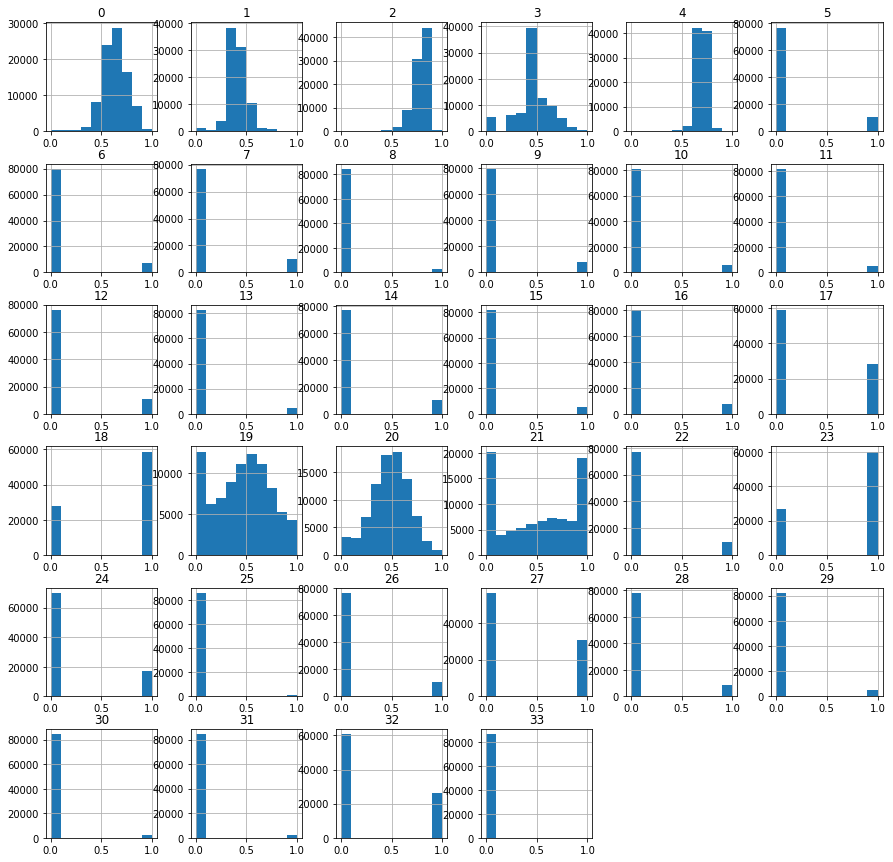

In [12]:
pd.DataFrame(df_train_tfm).hist(figsize=(15,15))
plt.show()

In [13]:
multi_data = MultimodalDataLoader(audio_dataset=train_audio,
                                  dataset=train_text)
multi_data_valid = MultimodalDataLoader(audio_dataset=valid_audio,
                                  dataset=valid_text)
multi_db = DataBunch(multi_data, multi_data_valid)

## Model setup

In [14]:
GPU = True

In [15]:
audio_sz = train_audio.feature_size
vocab_sz = 10002
emb_sz = 400
n_hid = 1150
n_layers = 3
pad_token = 1
qrnn = False
bidir = False
drop_mult = 0.5
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * drop_mult
hidden_p = dps[4]
input_p = dps[0]
embed_p = dps[3]
weight_p = dps[2]
tie_weights = True
output_p = dps[1]
bias = True

class MultiModalRNN(RNNCore):
    def __init__(self, audio_sz, output_p, bias, tie_encoder:bool=True, **kwargs):
        super(MultiModalRNN, self).__init__(**kwargs)
        self.rnns = None
        self.audio_sz = audio_sz
        self.multimode = [nn.LSTM(emb_sz + audio_sz if l == 0 else n_hid,
                                  (n_hid if l != n_layers - 1 else emb_sz)//self.ndir,
                                  1, bidirectional=bidir) for l in range(n_layers)]
        self.multimode = [WeightDropout(rnn, weight_p) for rnn in self.multimode]
        self.multimode = torch.nn.ModuleList(self.multimode)
        
        if tie_encoder:
            enc = self.encoder
        else:
            enc = None
        
        self.multidecoder = LinearDecoder(vocab_sz,
                                          emb_sz,
                                          output_p,
                                          tie_encoder=enc,
                                          bias=bias)
        
    def forward(self, input:LongTensor, input_audio:Tensor)->Tuple[Tensor,Tensor,Tensor]:
        sl,bs = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(self.encoder_dp(input))
        raw_output = torch.cat([raw_output, input_audio], dim=2)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.multimode, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden)
        
        output = self.multidecoder.output_dp(outputs[-1])
        decoded = self.multidecoder.decoder(output.view(output.size(0)*output.size(1),
                                                        output.size(2)))
        
        return decoded, raw_outputs, outputs
    
    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz)//self.ndir
        return self.weights.new(self.ndir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.multimode if hasattr(r, 'reset')]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]
        else: self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]
    
multimodal_rnn = MultiModalRNN(audio_sz=audio_sz,
                              vocab_sz=vocab_sz,
                              emb_sz=emb_sz,
                              n_hid=n_hid,
                              n_layers=n_layers,
                              pad_token=pad_token,
                              qrnn=qrnn,
                              bidir=bidir,
                              hidden_p=hidden_p,
                              input_p=input_p,
                              embed_p=embed_p,
                              weight_p=weight_p,
                              output_p=output_p,
                              bias=bias,
                              tie_encoder=tie_weights)

multimodal_rnn

MultiModalRNN(
  (encoder): Embedding(10002, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(10002, 400, padding_idx=1)
  )
  (rnns): None
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
  (multimode): ModuleList(
    (0): WeightDropout(
      (module): LSTM(434, 1150)
    )
    (1): WeightDropout(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDropout(
      (module): LSTM(1150, 400)
    )
  )
  (multidecoder): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10002, bias=True)
    (output_dp): RNNDropout()
  )
)

In [16]:
learn = RNNLearner(multi_db, multimodal_rnn)

In [17]:
DOWNLOAD_MODEL_WEIGHTS = False
weights_url = 'https://storage.googleapis.com/w210-capstone/3.2-ULMFiT-108k_best.pth'

if DOWNLOAD_MODEL_WEIGHTS:
    Path(MODEL_PATH/'models').mkdir(exist_ok=True)
    download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=True)

In [18]:
PRETRAINED_TO_MULTI = {
    '0.encoder.weight': 'encoder.weight',
    '0.encoder_dp.emb.weight': 'encoder_dp.emb.weight',
    '0.rnns.0.weight_hh_l0_raw': 'multimode.0.weight_hh_l0_raw',
    '0.rnns.0.module.weight_ih_l0': 'multimode.0.module.weight_ih_l0',
    '0.rnns.0.module.weight_hh_l0': 'multimode.0.module.weight_hh_l0',
    '0.rnns.0.module.bias_ih_l0': 'multimode.0.module.bias_ih_l0',
    '0.rnns.0.module.bias_hh_l0': 'multimode.0.module.bias_hh_l0',
    '0.rnns.1.weight_hh_l0_raw': 'multimode.1.weight_hh_l0_raw',
    '0.rnns.1.module.weight_ih_l0': 'multimode.1.module.weight_ih_l0',
    '0.rnns.1.module.weight_hh_l0': 'multimode.1.module.weight_hh_l0',
    '0.rnns.1.module.bias_ih_l0': 'multimode.1.module.bias_ih_l0',
    '0.rnns.1.module.bias_hh_l0': 'multimode.1.module.bias_hh_l0', 
    '0.rnns.2.weight_hh_l0_raw': 'multimode.2.weight_hh_l0_raw', 
    '0.rnns.2.module.weight_ih_l0': 'multimode.2.module.weight_ih_l0',
    '0.rnns.2.module.weight_hh_l0': 'multimode.2.module.weight_hh_l0',
    '0.rnns.2.module.bias_ih_l0': 'multimode.2.module.bias_ih_l0',
    '0.rnns.2.module.bias_hh_l0': 'multimode.2.module.bias_hh_l0',
    '1.decoder.weight': 'multidecoder.decoder.weight',
    '1.decoder.bias': 'multidecoder.decoder.bias'
}

map_weights(learn,
            INIT_MODEL_PATH/f'models/{init_model_name}_best.pth',
            MODEL_PATH/f'tmp/itos.pkl',
            PRETRAINED_TO_MULTI)

In [11]:
# def cpu_load(self, name:PathOrStr):
#     """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
#        We need these because the fastai load function doesn't allow for a remapping of the storage location."""
#     self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

# setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [12]:
# if not GPU:
#     learn.cpu_load(f'{model_name}_best')
# else:
#     learn.load(f'{model_name}_best')

## Training

In [19]:
TRAIN = True

In [20]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [21]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [28]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

KeyboardInterrupt: 

In [22]:
if TRAIN:
    learn.unfreeze()
    learn.fit_one_cycle(10, 1e-3, callbacks=[save_callback])

Total time: 2:25:43
epoch  train_loss  valid_loss  accuracy
1      2.598845    2.816511    0.463164  (14:36)
2      2.610840    2.815431    0.463534  (14:31)
3      2.638642    2.823238    0.462790  (14:32)
4      2.621132    2.820838    0.463037  (14:33)
5      2.637183    2.813993    0.463445  (14:35)
6      2.639405    2.812547    0.464063  (14:33)
7      2.606266    2.805101    0.464891  (14:36)
8      2.641790    2.801087    0.465622  (14:35)
9      2.614442    2.798441    0.465965  (14:32)
10     2.582968    2.797974    0.466002  (14:35)



In [23]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.7979743


#### Learning Loss

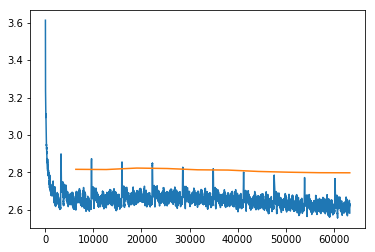

In [24]:
if TRAIN:
    learn.recorder.plot_losses()

In [27]:
learn.path = Path(MODEL_PATH)
learn.save(f'{model_name}')

## Text Generation

In [ ]:
def generate_step(learner, context, audio, context_length, temp=1):
    
    # FIX THIS
    audio_size = train_audio.feature_size

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    if audio is None:
        audio_features = Tensor([0]*audio_size*len(context))\
        .view(-1, 1, audio_size).cuda()
    else:
        audio_features = np.tile(audio, len(context))
        audio_features = Tensor(audio_features).view(-1, 1, len(audio)).cuda()
        
    # forward pass the "context" into the model
    result, *_ = model(context, audio_features)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def get_word_from_index(idx):

    return data_lm.valid_ds.vocab.textify([idx])


def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = 'xeol \n'
        elif 'xbol' in word:
            word = 'xbol'
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], audio=None, max_len=500, GPU=False, context_length=20, beam_width=5, temp=1, verbose=True, graph=False):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    if graph:
        optimization_graph = Digraph()

    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, audio, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
                
                if graph:
                    optimization_graph.node("%d_%d" % (word_number, next_word_idx), "%s (%.2f)" % (get_word_from_index(next_word_idx), candidate[1]))
                    optimization_graph.edge("%d_%d" % (word_number - 1, context[len(context) -1]), "%d_%d" % (word_number, next_word_idx))
                
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')

    if graph:
        now = str(datetime.now())
        optimization_graph.render(directory='graph_viz/', filename=now, cleanup=True)
    return context_and_scores
    

In [ ]:
df_valid.sample(5)

In [63]:
xx = valid_audio[9126] # benny benassi
yy = valid_audio[13522] # Siouxsie and the Banshees

In [ ]:
final_scores = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol [verse-1]',
                             audio=xx,
                             max_len=80, context_length=200,
                             beam_width=2, verbose=False,
                             temp=1.3, graph=False)

In [ ]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')